In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from src.features.feature_engineering_1 import *
from src.features.q3_plots import *
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

In [3]:
# Définition des années de train
years_train = ['2016', '2017', '2018', '2019']

In [4]:
# Chargement des données d'entrainement
data = get_all_season_data(years_train)
data.head()

,period,period_type,period_time,game_seconds,gameID,attacking_team_id,attacking_team_name,play_type,shooter,goalie,...,empty_net,strength,last_event_type,last_event_x,last_event_y,time_since_last_event,distance_from_last_event,powerplay_duration,home_team_players,away_team_players
0,1,REGULAR,01:11,71,2016020001,10,Toronto Maple Leafs,Shot,Mitchell Marner,Craig Anderson,...,NaN,NaN,Blocked Shot,-61.0,11.0,1,17.088007,0,5,5
1,1,REGULAR,02:53,173,2016020001,9,Ottawa Senators,Shot,Chris Kelly,Frederik Andersen,...,NaN,NaN,Giveaway,54.0,-5.0,5,36.715120,0,5,5
2,1,REGULAR,04:01,241,2016020001,9,Ottawa Senators,Shot,Cody Ceci,Frederik Andersen,...,NaN,NaN,Missed Shot,-72.0,0.0,18,102.318131,0,5,5
3,1,REGULAR,04:46,286,2016020001,9,Ottawa Senators,Shot,Erik Karlsson,Frederik Andersen,...,NaN,NaN,Missed Shot,77.0,-2.0,19,45.880279,0,5,5
4,1,REGULAR,06:46,406,2016020001,10,Toronto Maple Leafs,Shot,Martin Marincin,Craig Anderson,...,NaN,NaN,Hit,47.0,34.0,16,81.221918,0,5,5


In [5]:
# Ajout des features de distance et d'angle
data = add_new_features(data)
data.head()

,period,period_type,period_time,game_seconds,gameID,attacking_team_id,attacking_team_name,play_type,shooter,goalie,...,last_event_y,time_since_last_event,distance_from_last_event,powerplay_duration,home_team_players,away_team_players,distance_to_net,shot_angle,is_goal,is_empty_net
0,1,REGULAR,01:11,71,2016020001,10,Toronto Maple Leafs,Shot,Mitchell Marner,Craig Anderson,...,11.0,1,17.088007,0,5,5,13.0,23.0,0,0
1,1,REGULAR,02:53,173,2016020001,9,Ottawa Senators,Shot,Chris Kelly,Frederik Andersen,...,-5.0,5,36.715120,0,5,5,13.0,77.0,0,0
2,1,REGULAR,04:01,241,2016020001,9,Ottawa Senators,Shot,Cody Ceci,Frederik Andersen,...,0.0,18,102.318131,0,5,5,76.0,-30.0,0,0
3,1,REGULAR,04:46,286,2016020001,9,Ottawa Senators,Shot,Erik Karlsson,Frederik Andersen,...,-2.0,19,45.880279,0,5,5,58.0,-15.0,0,0
4,1,REGULAR,06:46,406,2016020001,10,Toronto Maple Leafs,Shot,Martin Marincin,Craig Anderson,...,34.0,16,81.221918,0,5,5,62.0,27.0,0,0


In [6]:
# Sélection de la caractéristique distance_to_net et des labels is_goal
df1 = data[['distance_to_net', 'is_goal']]
df1.head()

,distance_to_net,is_goal
0,13.0,0
1,13.0,0
2,76.0,0
3,58.0,0
4,62.0,0


In [7]:
# Suppression des valeurs NaN
df1 = df1.dropna()

In [8]:
y1 = df1['is_goal'].values
X1 = df1['distance_to_net'].values

In [9]:
# Split des données d'entrainement en train et val
X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, test_size=0.2)

# Reshpae des array
X_train1 = X_train1.reshape(X_train1.shape[0], 1)
X_val1 = X_val1.reshape(X_val1.shape[0], 1)

**Question 1**

In [10]:
modele_base1 = LogisticRegression()
modele_base1.fit(X_train1, y_train1)

LogisticRegression()

In [11]:
# Prédiction des données de val
y_pred1 = modele_base1.predict(X_val1)

In [12]:
confusion_matrix(y_val1, y_pred1)

array([[59215,     0],
       [ 6250,     0]], dtype=int64)

In [13]:
print('Accuracy :', accuracy_score(y_val1, y_pred1))
print('Recall :', recall_score(y_val1, y_pred1))

Accuracy : 0.9045291377071718
Recall : 0.0


Nous remarquons que la précision du modèle est très bonne. Cependant ce résultat est trompeur car le modèle prédit que tous les exemples de l'ensemble de validation sont de la classe 0 (à l'aide de la matrice de confusion)

En calculant le Recall on se rend compte qu'il vaut 0. C'est un très très mauvais résultat.

Les problèmes possibles sont :
- Pas assez d'exemple de la classe 1 (pour un but)
- Seul la distance ne suffit pas pour prédire correctement 

**Question 2**

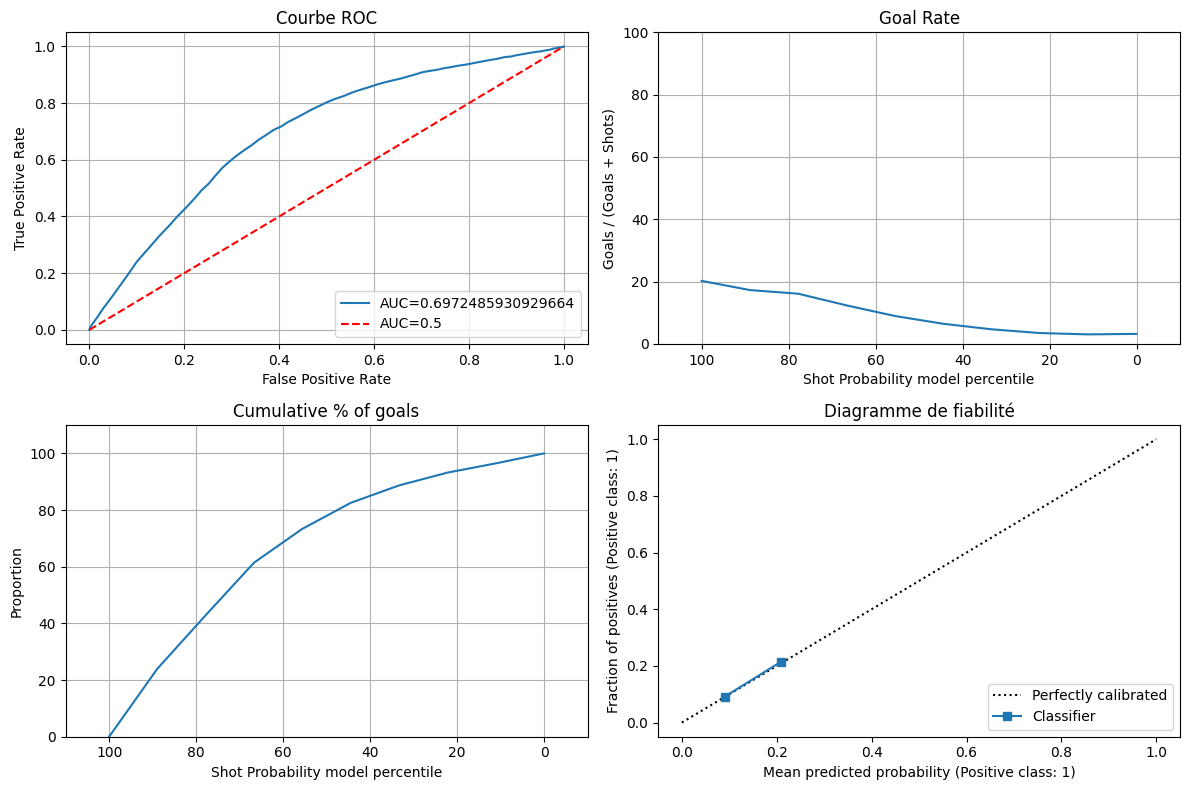

In [14]:
y_pred_proba1 = modele_base1.predict_proba(X_val1)[:, 1]
plot_metrics(y_val1, y_pred_proba1)

In [20]:
type(y_val1)

numpy.ndarray

**Question 3**

Utilisation de la caractéristique d'angle uniquement

In [14]:
#utilisation de la caractéristique d'angle
df2 = data[['shot_angle', 'is_goal']]
df2 = df2.dropna()
df2.head()

,shot_angle,is_goal
0,23.0,0
1,77.0,0
2,30.0,0
3,15.0,0
4,27.0,0


In [15]:
y2 = df2['is_goal'].values
X2 = df2['shot_angle'].values

# Split des données d'entrainement en train et val
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size=0.2)

# Reshpae des array
X_train2 = X_train2.reshape(X_train2.shape[0], 1)
X_val2 = X_val2.reshape(X_val2.shape[0], 1)

In [16]:
modele_base2 = LogisticRegression()
modele_base2.fit(X_train2, y_train2)

LogisticRegression()

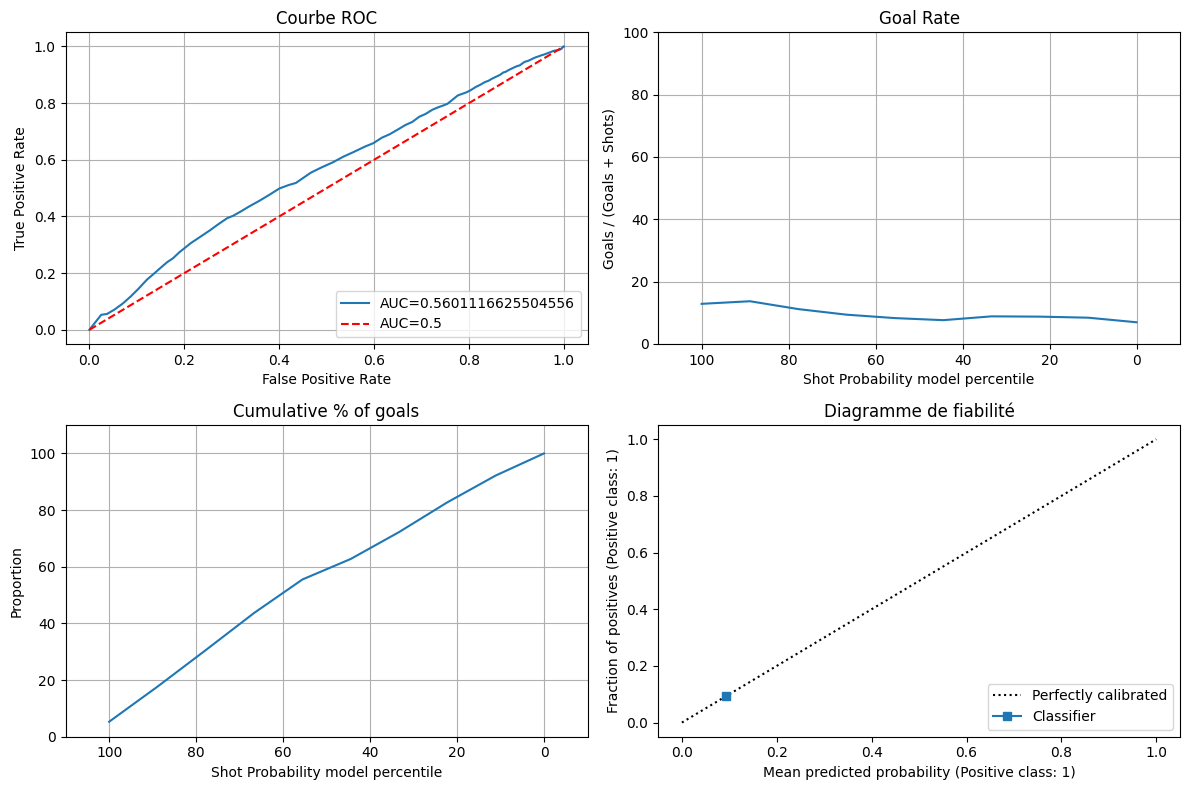

In [17]:
y_pred_proba2 = modele_base2.predict_proba(X_val2)[:, 1]
plot_metrics(y_val2, y_pred_proba2)

Utilisation de la caractéristique d'angle et distance

In [18]:
#utilisation de la caractéristique d'angle
df3 = data[['distance_to_net', 'shot_angle', 'is_goal']]
df3 = df3.dropna()
df3.head()

,distance_to_net,shot_angle,is_goal
0,13.0,23.0,0
1,13.0,77.0,0
2,76.0,30.0,0
3,58.0,15.0,0
4,62.0,27.0,0


In [19]:
y3 = df3['is_goal'].values
X3 = df3[['distance_to_net', 'shot_angle']].values

# Split des données d'entrainement en train et val
X_train3, X_val3, y_train3, y_val3 = train_test_split(X3, y3, test_size=0.2)

In [20]:
modele_base3 = LogisticRegression()
modele_base3.fit(X_train3, y_train3)

LogisticRegression()

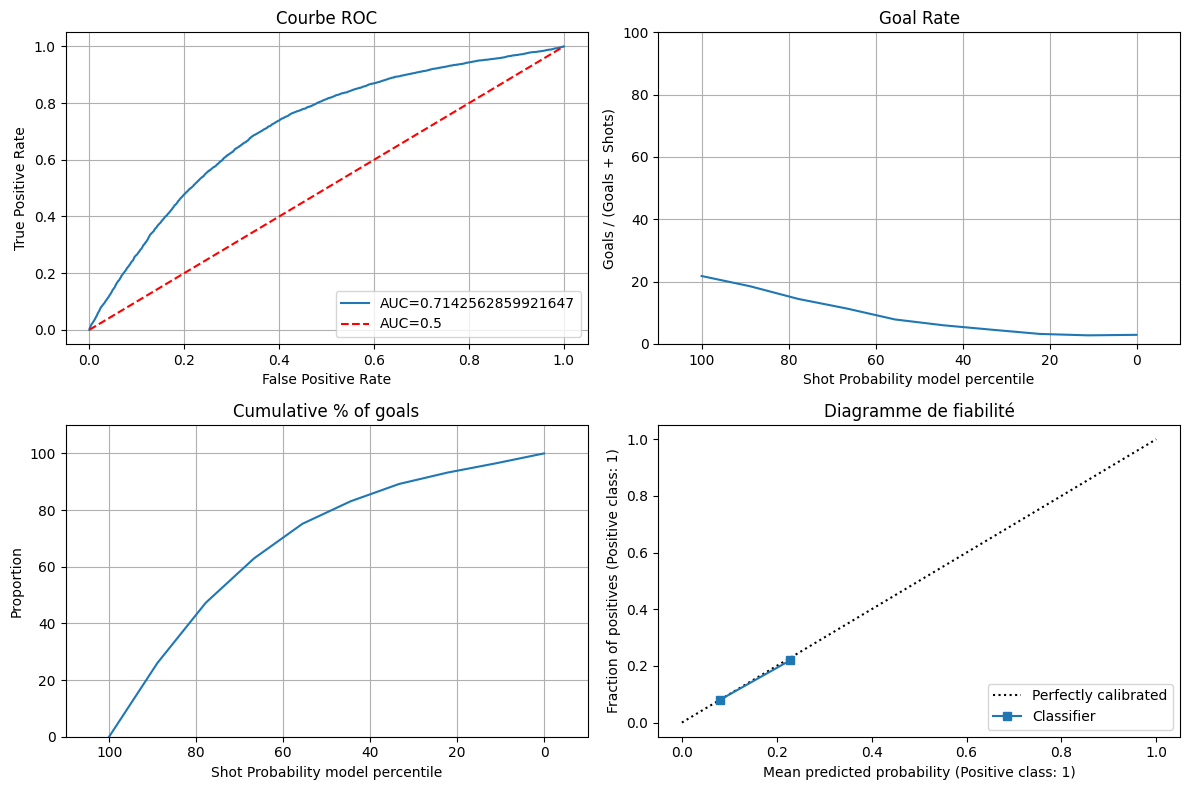

In [21]:
y_pred_proba3 = modele_base3.predict_proba(X_val3)[:, 1]
plot_metrics(y_val3, y_pred_proba3)

$\textbf{Ligne de base aléatoire}$

In [22]:
random_proba = np.random.uniform(0, 1, len(y_val3))

In [23]:
y_pred_proba4 = (random_proba > 0.5) * 1
print(accuracy_score(y_val3, y_pred_proba4))

0.4975483082563202


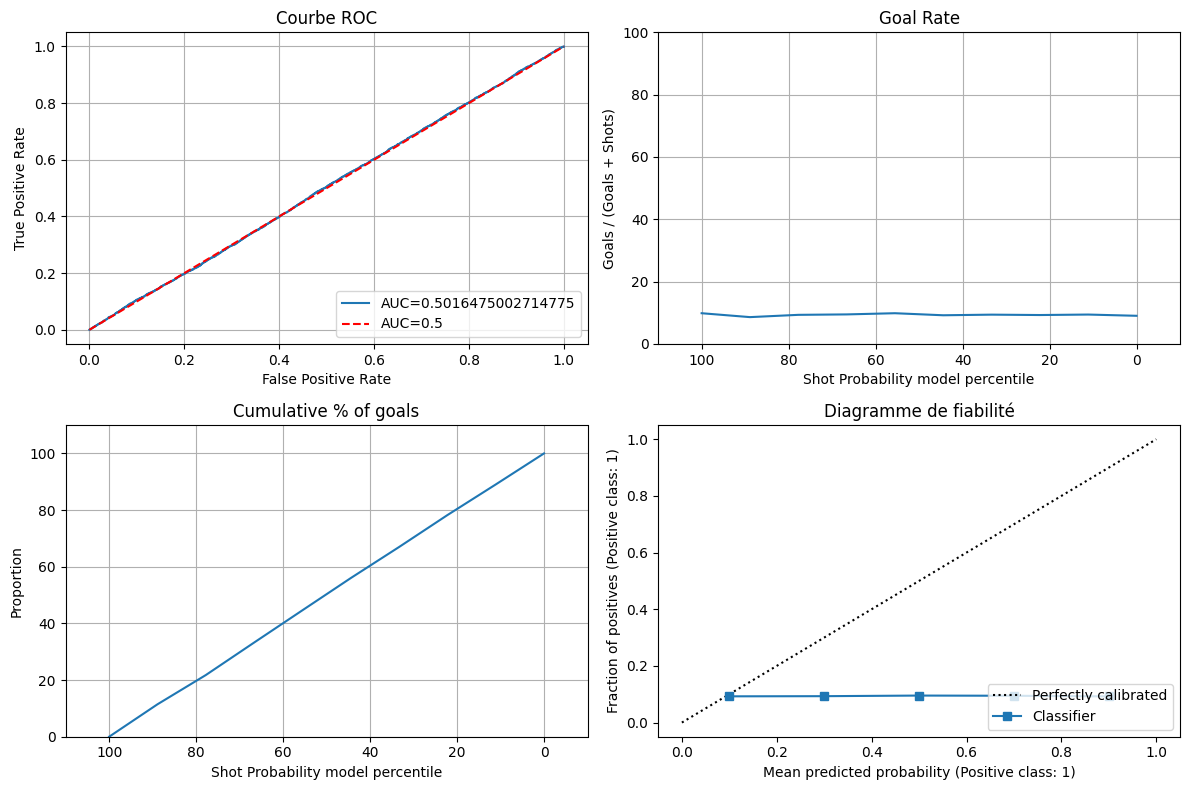

In [24]:
plot_metrics(y_val3, random_proba)

$\text{Superposition de toutes les courbes}$

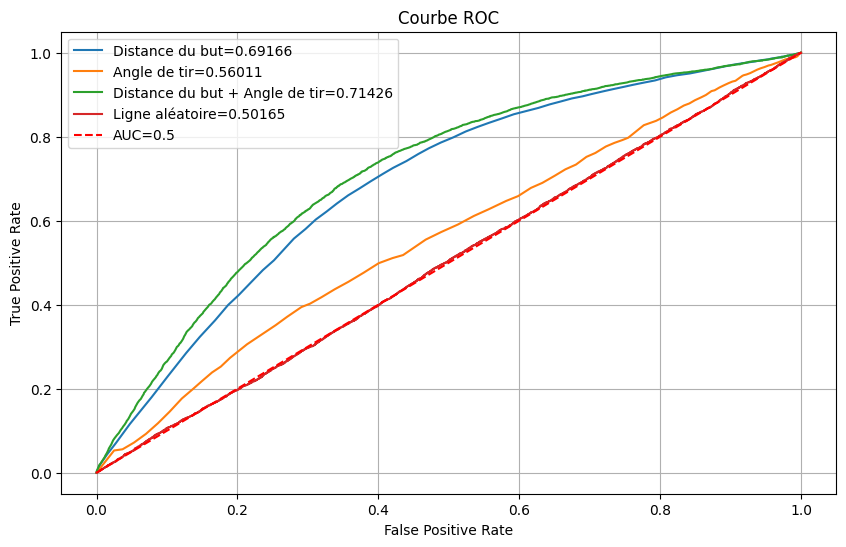

In [25]:
list_y_val = [y_val1, y_val2, y_val3, y_val3]
list_y_proba = [y_pred_proba1, y_pred_proba2, y_pred_proba3, random_proba]
models = ['Distance du but', 'Angle de tir', 'Distance du but + Angle de tir', 'Ligne aléatoire']

plot_all_roc_curve(list_y_val, list_y_proba, models)

Plus l'AUC est proche de 1, meilleure est la performance du modèle. Dans ce cas en utilisant à la fois les caractéristiques de distance et d'angle, le modèle entrainé est le plus performant que si on l'avait entrainé en utilisant soit la distance soit l'angle.

Toutefois nous remarquons qu'en utilisant seulement la caractéristique de distance, les performances du modèle sont meilleures comparé au modèle entrainé en utilisant seulement la caractéristique d'angle. On pourrait conclure que la distance du but est une caractéristique plus importante que celle de l'angle de tir.

Quand on tire uniformément les probabilité de but, l'AUC est proche de 0.5 ce qui équivaut à prédire au hasard s'il y a but ou pas.

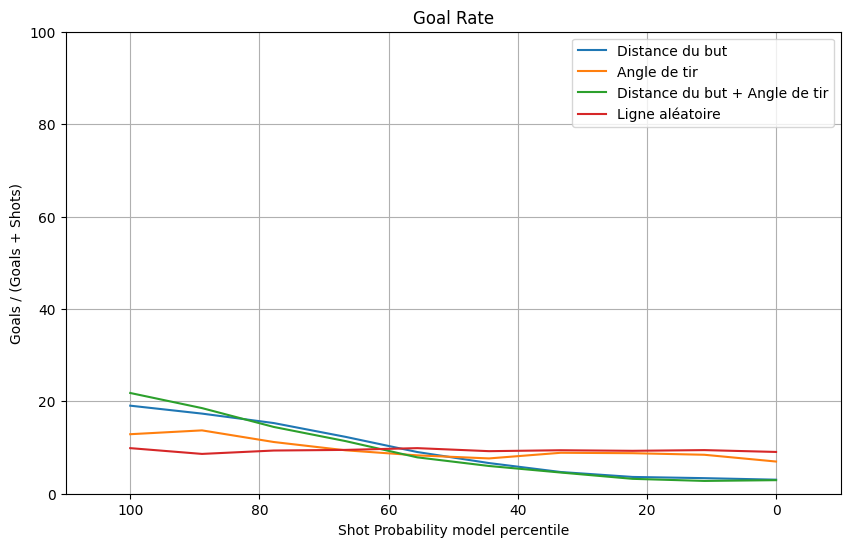

In [26]:
plot_all_goal_rate(list_y_val, list_y_proba, models)

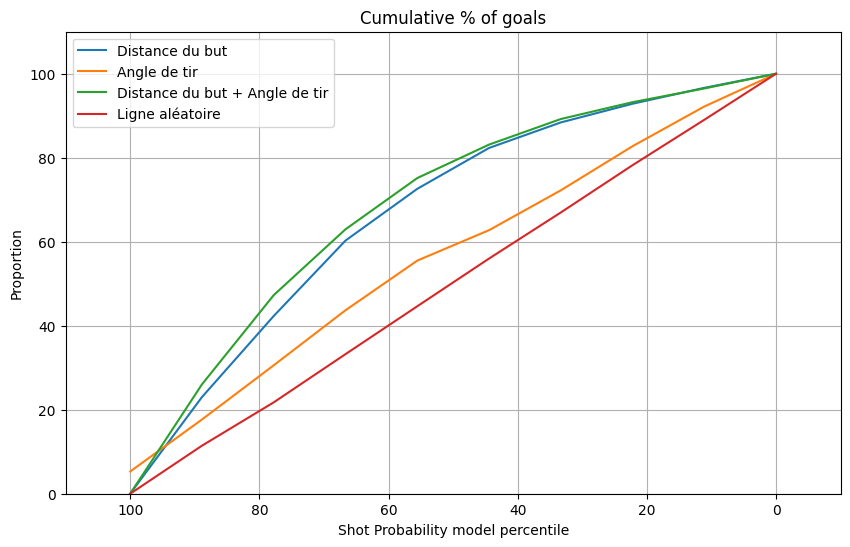

In [27]:
plot_all_cumulative_percent_goal(list_y_val, list_y_proba, models)

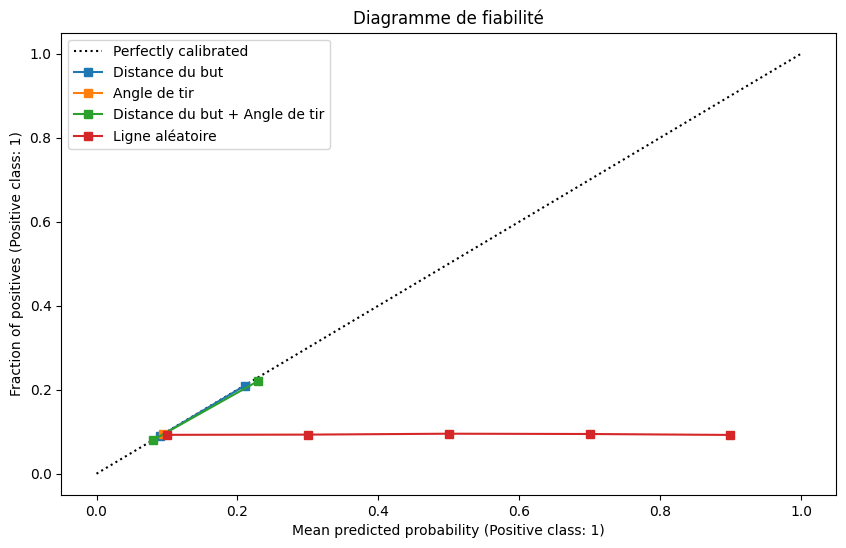

In [28]:
plot_all_fiability_diagram(list_y_val, list_y_proba, models)